# 1. Introducción
A continuacion se desarolla el calculo de sumas sucesivas usando CPU y GPU. Este algoritmo suele verse, por ejemplo, en el calculo del balance de una caja de un comercio.

*   CPU: Este algoritmo recorrerá posicion por posición un arreglo de numeros aleatorios e irá almecenando en una unica variable, el resultado de la suma sucesiva de las posiciones del arreglo unidireccional comentado anteriormente.
*   GPU: Este algoritmo realiza una reducción paralela del arreglo produciendo asi, un unico resultado. Se agrupan de a pares elementos del arreglos y se realiza la suma de estos, todo realizado en forma paralela por distintos threads del GPU. Esto se produce hasta que se termina reduciendo todo el arreglo y se encuentra el resultado.




>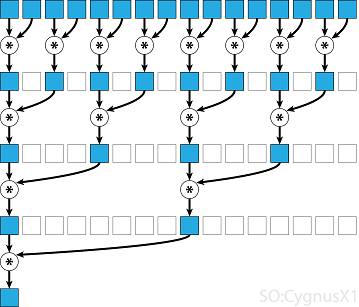


# 2. Armado del Ambiente









### 2.1. Armado del ambiente para ejecución CPU
> No se requiere ninguna accion para este tipo de ejecución

### 2.2. Armado del ambiente para ejecución GPU
>   Configuramos el notebook con acelerador por hardware como "GPU"

>   Instalamos "pycuda", el modulo para python encargado de facilitar al programador el acceso a CUDA de Nvidia.

In [ ]:
!pip install pycuda

# 3 Desarrallo

### 3.1. Version CPU

In [ ]:
# --------------------------------------------
#@title 3.1 Parámetros de ejecución { vertical-output: true }
cant_elements = 256 #@param {type: "number"}
# --------------------------------------------

from datetime import datetime
import numpy

tiempo_total = datetime.now()

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

# CPU - Defino la memoria de los vectores en cpu.
x_cpu = numpy.random.randn( cant_elements )
x_cpu = x_cpu.astype( numpy.int32 )

r_cpu = numpy.array( [0] )
r_cpu = r_cpu.astype( numpy.int32 )

tiempo_alg = datetime.now()

for i in range(0, cant_elements):
  r_cpu[0] += x_cpu[i]

tiempo_gpu = datetime.now() - tiempo_alg

# CPU - Informo el resutlado.
#print( "------------------------------------")
#print( "X: " )
#print( x_cpu )
#print( "------------------------------------")
#print( "R: " )
#print( r_cpu )


tiempo_total = datetime.now() - tiempo_total

print("Cantidad de elementos: ", cant_elements )
print("Tiempo CPU/TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo ALGORITMO: ", tiempo_en_ms( tiempo_alg ), "[ms]" )

Cantidad de elementos:  256
Tiempo CPU/TOTAL:  0.475 [ms]
Tiempo ALGORITMO:  0.204 [ms]


### 3.2. Version GPU

In [ ]:
# --------------------------------------------
#@title 3.1 Parámetros de ejecución { vertical-output: true }
cant_elements = 256 #@param {type: "number"}
# --------------------------------------------


from datetime import datetime
import numpy
import sys

try:
  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule
except :
  sys.exit("No se han podido importar las librerias necesarias. Lea el apartado de 'armado de ambiente' e intente nuevamente") 

tiempo_total = datetime.now()
# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0


# CPU - Defino la memoria de los vectores en cpu.
x_cpu = numpy.random.randn( cant_elements )
x_cpu = x_cpu.astype( numpy.int32 )

r_cpu = numpy.array( [0] )
r_cpu = r_cpu.astype( numpy.int32 )

# CPU - reservo la memoria GPU.
try:
  x_gpu = cuda.mem_alloc( x_cpu.nbytes )
  r_gpu = cuda.mem_alloc( r_cpu.nbytes )
except :
  sys.exit("Error al reservar memoria en GPU") 

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( x_gpu, x_cpu )
cuda.memcpy_htod( r_gpu, r_cpu )


# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void reduce0(int n, int *input, int *output) {

  unsigned int tid = threadIdx.x;

  __syncthreads();

  for (unsigned int j = 1; j < n; j *= 2) {
    if (tid % (2 * j) == 0) {
    input[tid] += input[tid + j];
  }

  __syncthreads();
  }

  if (tid == 0) *output = input[0];
}
""") 
# CPU - Genero la función kernel.
kernel = module.get_function("reduce0")

dim_hilo = 1024
dim_bloque = 1

tiempo_gpu = datetime.now()
kernel( numpy.int32(cant_elements), x_gpu, r_gpu, block=( dim_hilo, 1, 1 ),grid=(dim_bloque, 1,1) )
tiempo_gpu = datetime.now() - tiempo_gpu

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( r_cpu, r_gpu )

# CPU - Informo el resutlado.
#print( "------------------------------------")
#print( "X: " )
#print( x_cpu )
#print( "------------------------------------")
#print( "R: " )
#print( r_cpu )


tiempo_total = datetime.now() - tiempo_total

print("Cantidad de elementos: ", cant_elements )
print("Thread x: ", dim_hilo, ", Bloque x:", dim_bloque )
print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo CPU: ", tiempo_en_ms( tiempo_total - tiempo_gpu ), "[ms]" )
print("Tiempo GPU/ALGORITMO: ", tiempo_en_ms( tiempo_gpu   ), "[ms]" )

Thread x:  1024 , Bloque x: 1
Cantidad de elementos:  256
Thread x:  1024 , Bloque x: 1
Tiempo TOTAL:  928.848 [ms]
Tiempo CPU:  927.246 [ms]
Tiempo GPU/ALGORITMO:  1.602 [ms]


# 4. Tabla de Pasos

### 4.1. Version CPU
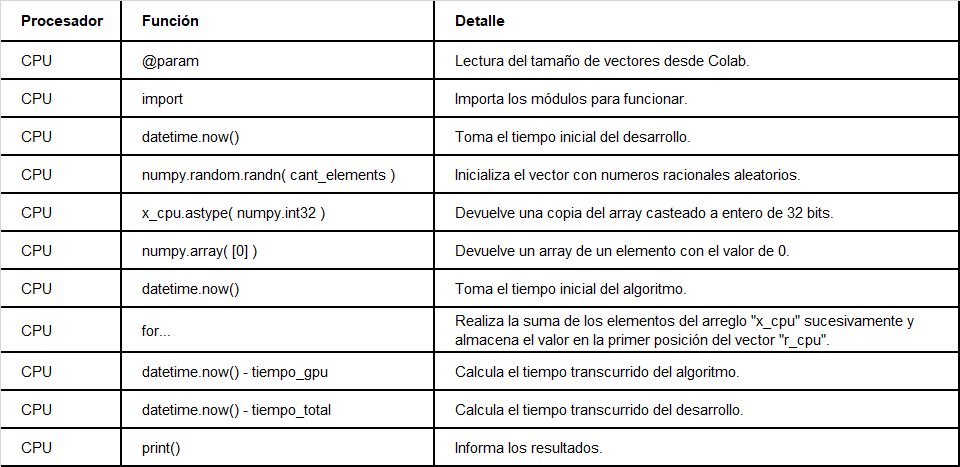

### 4.2. Versión GPU
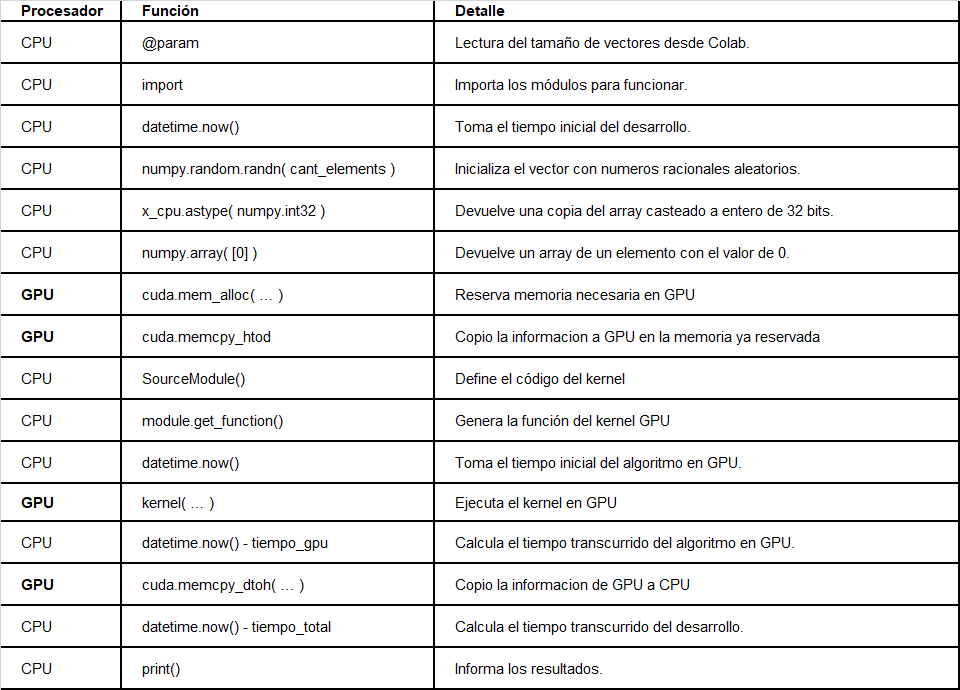

# 5. Conclusión

De los resultados de rendimientos vemos que la versión GPU es sumamente mas rapida. Esto era de esperarse debido a como se manejan las sumas previas al resultado final. Como puede verse en la imagen de la seccion uno, el algoritmo GPU divide el arreglo en varias partes y realiza calculos de manera paralela, generando asi una disminución en el tiempo de ejecucion. Por otro lado, podemos notar que la gestion de memoria entre CPU y GPU genera una carga no beneficiosa para el desarrollo GPU, provocando que el desarrollo CPU sea mas rápido en terminos generales.

De este ejercicio puede entenderse que a menos que valga la pena la carga extra que genera la gestión de GPU sobre el tiempo total del desarrollo, deberá recurrirse a la version en CPU.

Este algoritmo, en su proxima versión, podría calcular la suma sucesiva de elementos de un arreglo cuando haya mas de un solo bloque. Para esto debera gestionarse la memoria compartida entre bloques.

# 6. Bibliografía


*   Python basico: [Github](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb)
*   Programacion paralela y distribuida: [SODIUM](http://so-unlam.com.ar/material-clase/HPC/Programación%20Paralela%20y%20Distribuida.pdf)
*   Introducción a Google Colab: [Github](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/google_colab_tutorial.pdf)
*   Rotación (Matemáticas): [Wikipedia](https://es.wikipedia.org/wiki/Rotación_(matemáticas))